# Training of the _isMuon_ model for _kaons_

In this notebook we setup the training for the isMuon model for _kaons_, based on a Deep Neural Network.

This notebook is part of a pipeline and requires the data preprocessed with the notebook [isMuon-preprocessing.ipynb](./isMuon-preprocessing.ipynb).

In [1]:
LOCAL = True
SAMPLE = "2016MU"

## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [4]:
DATA_PATH = "/home/mabarbet/PythonFastSim/data" if LOCAL else "/workarea/cloud-storage/mabarbet/data"

In [5]:
from feather_io import FeatherReader    

reader_train = FeatherReader(environ.get("ISMUON_KAON_TRAIN_DATA", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-train"), max_files=4)
ds_train = reader_train.as_tf_dataset()

reader_val = FeatherReader(environ.get("ISMUON_KAON_VAL_DATA", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-validation"), max_files=1)
ds_val = reader_val.as_tf_dataset()

We load a small batch of data to identify the shape of features and labels, and automate the definition of the neural network architecture.

In [6]:
X, y = next(iter(ds_train.batch(500_000)))
X.shape, y.shape

(TensorShape([500000, 4]), TensorShape([500000, 1]))

## Model definition

The function we are modelling is not a trivial one, requiring a sufficiently deep neural network.
In order to limit the effect of the vanishing gradient and make the trainig procedure faster, we are using the concept of Residual Layer, introducing skipping connections between the input and the output of each layer.

With residual layers, the neural network is trained to learn the deviation from identity which is a much less demanding task than learning the whole transformation.

The output layer of the neural network has a sigmoid activation function to be mapped into the interval 0-1 and being interpreted as the **probability** for the particle of **passing the isMuon criterion**.

In [7]:
from pidgan.players.classifiers import ResClassifier

model = ResClassifier(
    num_hidden_layers=10,
    mlp_hidden_units=128,
    mlp_hidden_activation="relu",
    mlp_hidden_kernel_regularizer=tf.keras.regularizers.L2(5e-5),
    mlp_dropout_rates=0.0,
    name="classifier",
)

In [8]:
model(X[:256])
model.summary()

Model: "classifier_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dropout_0[0][0]']           
                                                                                    

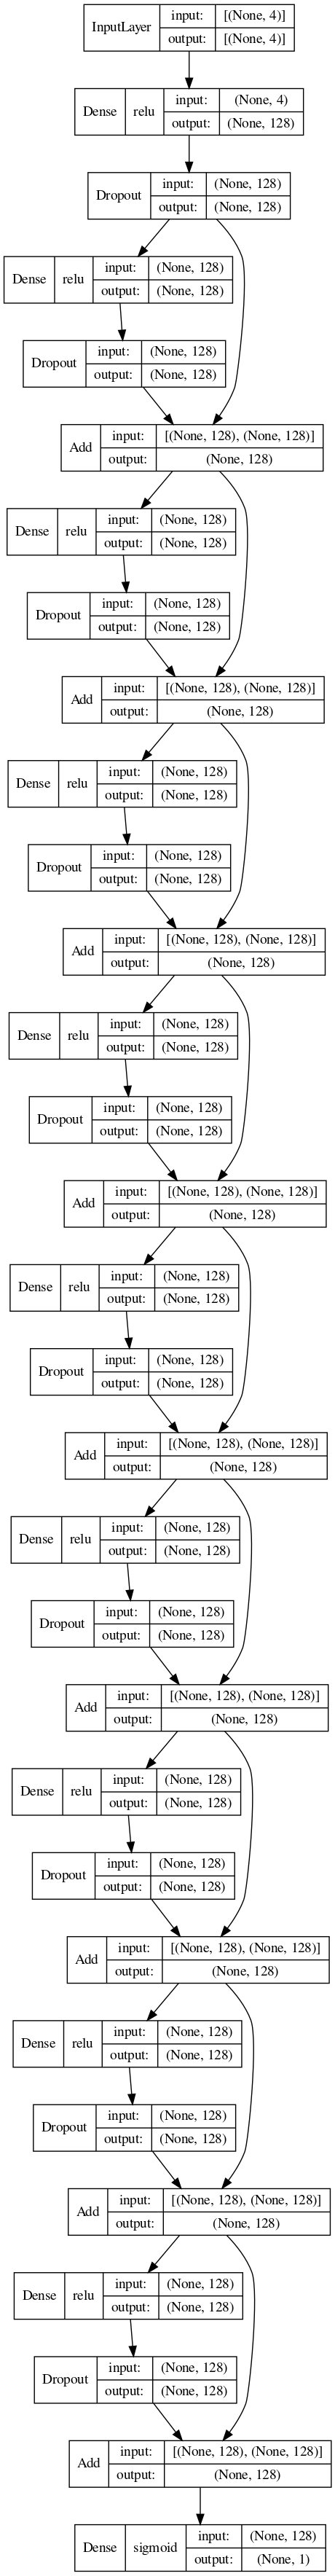

In [9]:
tf.keras.utils.plot_model(
    model.export_model,
    to_file="./images/isMuon-kaon-model.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

The rest of the training procedure is rather standard:
 * loss function: [binary cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
 * optimizer: [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop) or [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

In [10]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

To speed up convergence, we split the training procedure in two steps:
* First, we start with a high learning rate that is exponentially decreased by using a custom [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler), and with a binary cross-entropy loss with `label_smoothing` set to 0.05.
* Then, we operate some fine tuning by fixing the learning rate to the value reached by the scheduler, and by removing the `label_smoothing`.

In [11]:
model.compile(
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=tf.keras.metrics.AUC(name="auc"),
    optimizer=Adam(0.05),
)

In [12]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

lr_sched = LearnRateExpDecay(
    model.optimizer,
    decay_rate=0.1,
    decay_steps=50_000,
    verbose=True,
)

# early_stop = tf.keras.callbacks.EarlyStopping(
#     monitor="val_auc",
#     min_delta=1e-5,
#     patience=3,
#     mode="max",
# )

In [13]:
batch_size = 20_000
num_epochs = 200

data_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

callbacks = [lr_sched]  # [lr_sched, early_stop]

train = model.fit(data_train, epochs=num_epochs, validation_data=data_val, callbacks=callbacks)

Epoch 1/200
      4/Unknown - 6s 17ms/step - loss: 408.3273 - auc: 0.4948 - lr: 0.0500WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_begin` time: 0.0801s). Check your callbacks.
599/599 [==============================] - 23s 28ms/step - loss: 3.2545 - auc: 0.7010 - lr: 0.0493 - val_loss: 0.4189 - val_auc: 0.7145
Epoch 2/200
599/599 [==============================] - 15s 25ms/step - loss: 0.3751 - auc: 0.7192 - lr: 0.0480 - val_loss: 0.3432 - val_auc: 0.7232
Epoch 3/200
599/599 [==============================] - 16s 26ms/step - loss: 0.3271 - auc: 0.7213 - lr: 0.0467 - val_loss: 0.3121 - val_auc: 0.7281
Epoch 4/200
599/599 [==============================] - 16s 25ms/step - loss: 0.3039 - auc: 0.7230 - lr: 0.0454 - val_loss: 0.2943 - val_auc: 0.7291
Epoch 5/200
599/599 [==============================] - 15s 25ms/step - loss: 0.2892 - auc: 0.7240 - lr: 0.0442 - val_loss: 0.2815 - val_auc: 0.7313
Epoch 6/

In [14]:
from datetime import datetime

model.compile(
    loss=BinaryCrossentropy(label_smoothing=0.0),
    metrics=tf.keras.metrics.AUC(name="auc"),
    optimizer=Adam(1e-4),
)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=5)

callbacks = None  # [early_stop]

train_ft = model.fit(data_train, epochs=int(num_epochs/2.0), validation_data=data_val, callbacks=callbacks)

prefix = ""
timestamp = str(datetime.now())
timestamp = timestamp.split(".")[0].replace("-", "").replace(" ", "-")
for time, unit in zip(timestamp.split(":"), ["h", "m", "s"]):
    prefix += time + unit  # YYYYMMDD-HHhMMmSSs

Epoch 1/100
599/599 [==============================] - 19s 26ms/step - loss: 0.1524 - auc: 0.7263 - val_loss: 0.1489 - val_auc: 0.7348
Epoch 2/100
599/599 [==============================] - 15s 25ms/step - loss: 0.1506 - auc: 0.7315 - val_loss: 0.1487 - val_auc: 0.7369
Epoch 3/100
599/599 [==============================] - 15s 24ms/step - loss: 0.1506 - auc: 0.7319 - val_loss: 0.1486 - val_auc: 0.7367
Epoch 4/100
599/599 [==============================] - 15s 24ms/step - loss: 0.1505 - auc: 0.7320 - val_loss: 0.1486 - val_auc: 0.7371
Epoch 5/100
599/599 [==============================] - 15s 25ms/step - loss: 0.1505 - auc: 0.7321 - val_loss: 0.1486 - val_auc: 0.7369
Epoch 6/100
599/599 [==============================] - 15s 25ms/step - loss: 0.1505 - auc: 0.7322 - val_loss: 0.1486 - val_auc: 0.7368
Epoch 7/100
599/599 [==============================] - 15s 25ms/step - loss: 0.1505 - auc: 0.7323 - val_loss: 0.1485 - val_auc: 0.7373
Epoch 8/100
599/599 [==============================] - 

The two regimes are well visibile in the plot below, combining the two training phases in a single epoch count.

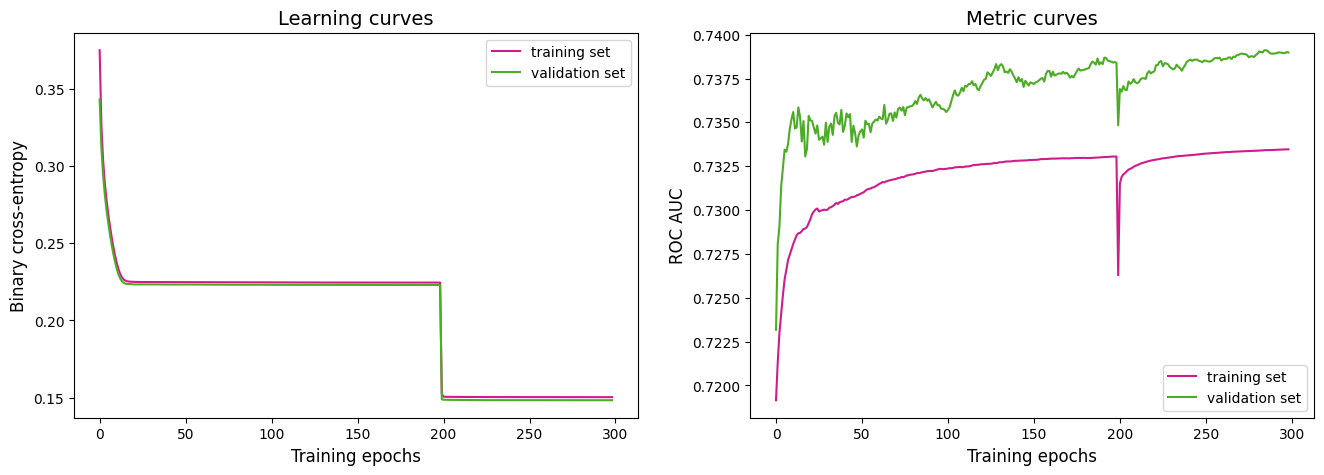

In [15]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Binary cross-entropy", fontsize=12)
plt.plot(train.history["loss"][1:] + train_ft.history["loss"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_loss"][1:] + train_ft.history["val_loss"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("ROC AUC", fontsize=12)
plt.plot(train.history["auc"][1:] + train_ft.history["auc"], lw=1.5, color="#d01c8b", label="training set")
plt.plot(train.history["val_auc"][1:] + train_ft.history["val_auc"], lw=1.5, color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

In [16]:
train_history = train.history.copy()
pd.DataFrame(train_history).to_csv(f"./exports/{prefix}-isMuon-kaon-train.csv")

train_history_ft = train_ft.history.copy()
train_history_ft.update({"lr": [1e-4 for _ in range(int(num_epochs/2.0))]})
pd.DataFrame(train_history_ft).to_csv(f"./exports/{prefix}-isMuon-kaon-train-ft.csv")

## A first, rough validation

While a proper validation of the model is demanded to a dedicated notebook (still to be prepared), here we check that the training was not completely failed and provides reasonable numbers.

In particular, we compare the distributions of the training labels and of the predictions.

Clearly, the training labels are either 1 or 0 because a particle passes either isMuon or not. Instead, the output of the neural network is a probability and hence it will be distributed between 0 and 1. 

The comparison is used to ensure that both the training labels and the network output are not unreasonable, for example collapsed into a single value or with training labels belonging to a single category.

In [17]:
reader_test = FeatherReader(environ.get("ISMUON_KAON_TEST_DATA", f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-test"), max_files=5)
ds_test = reader_test.as_tf_dataset()

In [18]:
X_test, y_test = next(iter(ds_test.batch(20_000_000).as_numpy_iterator()))
preds = model.predict(X_test, batch_size=50_000)

308/308 [==============================] - 2s 6ms/step


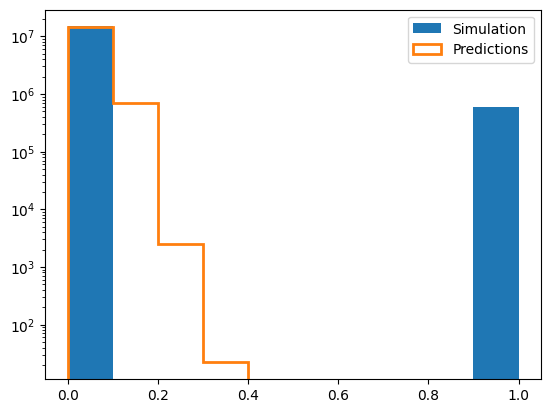

In [19]:
bins = np.linspace(0, 1, 11)
plt.hist(y_test, bins=bins, label="Simulation")
plt.hist(preds, bins=bins, histtype='step', linewidth=2, label="Predictions")
plt.yscale("log")
plt.legend()
plt.show()

Then we can compare the distribution of a preprocessed variable before and after the application of the isMuon criterion.

Here, for example, we consider the preprocessed of the momentum $p$.

Since the variable is preprocessed, without applying any cut (**Generated**) we have a perfectly normalized Gaussian.

Applying the criterion `isMuon == 1`, we get another distribution that we expect to model with decent approximation by applying the response of the trained neural networks as weights to the **Generated** dataset.

The comparison of the two histograms (obtained by applying a cut on the true isMuon or applying a weight on the isMuon probability) provides a first validation on the quality of the parametrization.

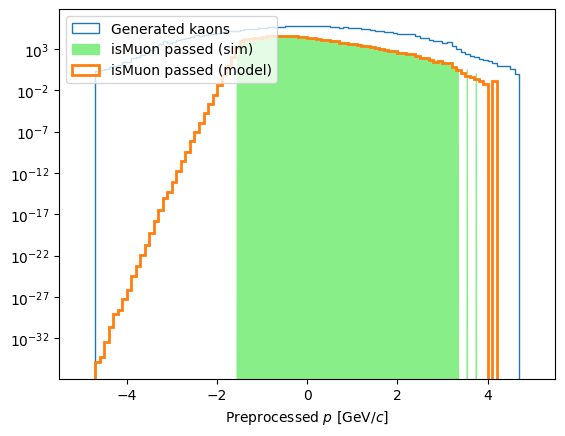

In [20]:
prep_p = X_test[:, 0]
bins = np.linspace(-5, 5, 101)

denominator, _ = np.histogram(prep_p, bins=bins)
true_numerator, _ = np.histogram(prep_p, bins=bins, weights=y_test.flatten())
predicted_numerator, _ = np.histogram(prep_p, bins=bins, weights=preds.flatten())

plt.xlabel("Preprocessed $p$ [GeV/$c$]")

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="Generated kaons", histtype='step')
plt.fill_between(
    (bins[1:] + bins[:-1])/2, np.zeros(len(true_numerator)), true_numerator,
    label="isMuon passed (sim)",
    color='#88ee88'
)
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="isMuon passed (model)", histtype='step', linewidth=2)

plt.legend(loc="upper left", fontsize=10)
plt.yscale("log")

plt.show()

## Data and model export

To simplify the preparation of LHCb figures and freeze the results obtained, the output of the trained model is exported and NumPy file and then uploaded to GitLab.

In [21]:
models_dir = "/home/mabarbet/PythonFastSim/models/isMuon_kaon_models"

In [22]:
import pickle

file_path = f"{models_dir}/tX_{SAMPLE}.pkl"

with open(file_path, "rb") as file:
    X_scaler = pickle.load(file)

In [23]:
import json

with open(f"{DATA_PATH}/isMuon-kaon-{SAMPLE}-test/definitions.json") as json_file:
    definitions = json.load(json_file)

In [24]:
from pidgan.utils.preprocessing import invertColumnTransformer

print(f"Shapes:", X_test.shape, y_test.shape, preds.shape)

X_post = invertColumnTransformer(X_scaler, X_test)
np.savez_compressed(
    f"./exports/{prefix}-isMuon-kaon-results.npz",
    feat_vars=np.array(definitions["features"]),
    label_vars=np.array(definitions["labels"]),
    results=np.c_[X_post, y_test, preds][:5_000_000],
)

Shapes: (15396424, 4) (15396424, 1) (15396424, 1)


Finally, we export the Keras model to the same folder where the preprocessing step was stored.

In [25]:
import os

default_output_model = f"{models_dir}/{prefix}_isMuon_kaon_{SAMPLE}_ann"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model

base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

tf.keras.models.save_model(
    model.export_model,
    filepath=output_model,
    save_format="tf",
)

INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/isMuon_kaon_models/20231229-21h57m50s_isMuon_kaon_2016MU_model/assets


INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/isMuon_kaon_models/20231229-21h57m50s_isMuon_kaon_2016MU_model/assets


: 